# Content-Based Filtering Recommender System - Product Recommender

## 1. Importing Libraries

In [1]:
# Import library to be used in the project
import pandas as pd
import numpy as np
import html
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

## 2. File Reading and Features Engineering: products

In [2]:
# Read the electronic products file
products_dataset_path = '../dataset/electronic_products.json'
products = pd.read_json(products_dataset_path, lines=True)

# Output the first 10 rows
products.head(10)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Electronics, Camera &amp; Photo, Video Survei...",,[The following camera brands and models have b...,,Genuine Geovision 1 Channel 3rd Party NVR IP S...,[],,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...","[>#3,092 in Tools &amp; Home Improvement &gt; ...",[],Camera &amp; Photo,,"January 28, 2014",$65.00,0011300000,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Electronics, Camera &amp; Photo]",,[This second edition of the Handbook of Astron...,,"Books ""Handbook of Astronomical Image Processi...",[0999470906],,33 Books Co.,[Detailed chapters cover these fundamental top...,"[>#55,933 in Camera &amp; Photo (See Top 100 i...","[0943396670, 1138055360, 0999470906]",Camera &amp; Photo,,"June 17, 2003",,0043396828,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Electronics, eBook Readers &amp; Accessories,...",,[A zesty tale. (Publishers Weekly)<br /><br />...,,One Hot Summer,"[0425167798, 039914157X]",,Visit Amazon's Carolina Garcia Aguilera Page,[],"3,105,177 in Books (",[],Books,,,$11.49,0060009810,[],[],NaN
3,"[Electronics, eBook Readers & Accessories, eBo...",,[],,Hurray for Hattie Rabbit: Story and pictures (...,"[0060219521, 0060219580, 0060219394]",,Visit Amazon's Dick Gackenbach Page,[],"2,024,298 in Books (","[0060219521, 0060219475, 0060219394]",Books,,,.a-section.a-spacing-mini{margin-bottom:6px!im...,0060219602,[],[],NaN
4,"[Electronics, eBook Readers & Accessories, eBo...",,[&#8220;sex.lies.murder.fame. is brillllli&#82...,,sex.lies.murder.fame.: A Novel,[],,Visit Amazon's Lolita Files Page,[],"3,778,828 in Books (",[],Books,,,$13.95,0060786817,[],[],NaN
5,"[Electronics, eBook Readers &amp; Accessories,...",,"[, ]",,College Physics,"[0073049557, 0134454170, 1118142063, 007733968...",,Visit Amazon's Alan Giambattista Page,[],"3,330,771 in Books (","[0073512141, 0077339681, 0073049557, 007304956...",Books,,,,0070524076,[],[],NaN
6,"[Electronics, eBook Readers & Accessories, eBo...",,[GIRL WITH A ONE-TRACK MIND: CONFESSIONS OF TH...,,Girl with a One-track Mind: Confessions of the...,[0330509691],,ABBY LEE,[],"3,304,037 in Books (",[B0719LDQR1],Books,,,$4.76,0091912407,[],[],NaN
7,"[Electronics, Portable Audio & Video, MP3 & MP...",,[Support system: Windows XP/Vsita/7 * SNR: 85d...,,abcGoodefg&reg; 4GB USB 2.0 Mp3 Music Player w...,"[B01NAJ3KQB, B00WYSPT0C, B00AF40U5G, B00OFVNM4...",,Crazy Cart,[Package Content: 1 x Display MP3 Player 1 x E...,"[>#177,454 in Electronics (See Top 100 in Elec...","[B01NAJ3KQB, B00OFVNM4G, B00L41WY8K, B07F34PNP...",All Electronics,"class=""a-bordered a-horizontal-stripes a-spa...","December 28, 2012",,0101635370,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
8,"[Electronics, Headphones, Earbud Headphones]",,"[, <b>True High Definition Sound:</b><br>With ...",,Wireless Bluetooth Headphones Earbuds with Mic...,[],,Enter The Arena,[Superb Sound Quality: Plays crystal clear aud...,[>#950 in Cell Phones & Accessories (See Top 1...,[],Home Audio & Theater,,"October 23, 2017",$7.99,0132492776,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
9,"[Electronics, Computers &amp; Accessories, Com...",,[],,Kelby Training DVD: Mastering Blend Modes in A...,[],,Kelby Training,[],"[>#932,732 in Computers &amp; Accessories &gt;...",[],Computers,,"December 9, 2011",,0132793040,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [3]:
print(products.shape)
# output: (rows, columns)

(104802, 19)


In [4]:
# retrieving column name
products.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')

In [5]:
# There are 104802 records with 19 columns
print(products.shape)

(104802, 19)


### 2.1 General Cleansing

#### 2.1.1 Drop Unnecessary columns

In [6]:
# keep: asin, title, brand, main_cat, category
products = products.drop(columns=['fit', 'description', 'rank', 'details', 'also_buy', 
                                  'tech1', 'tech2', 'feature', 'price', 'date', 'imageURL', 
                                  'also_view', 'imageURLHighRes', 'similar_item'], errors='ignore')
products.columns

Index(['category', 'title', 'brand', 'main_cat', 'asin'], dtype='object')

In [7]:
products = products[['asin', 'title', 'brand', 'main_cat', 'category']]
products.columns = ['product_id', 'product_name', 'brand_or_author', 'main_category', 'category_tags']

In [8]:
products.head(10)

,product_id,product_name,brand_or_author,main_category,category_tags
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision,Camera &amp; Photo,"[Electronics, Camera &amp; Photo, Video Survei..."
1,0043396828,"Books ""Handbook of Astronomical Image Processi...",33 Books Co.,Camera &amp; Photo,"[Electronics, Camera &amp; Photo]"
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page,Books,"[Electronics, eBook Readers &amp; Accessories,..."
3,0060219602,Hurray for Hattie Rabbit: Story and pictures (...,Visit Amazon's Dick Gackenbach Page,Books,"[Electronics, eBook Readers & Accessories, eBo..."
4,0060786817,sex.lies.murder.fame.: A Novel,Visit Amazon's Lolita Files Page,Books,"[Electronics, eBook Readers & Accessories, eBo..."
5,0070524076,College Physics,Visit Amazon's Alan Giambattista Page,Books,"[Electronics, eBook Readers &amp; Accessories,..."
6,0091912407,Girl with a One-track Mind: Confessions of the...,ABBY LEE,Books,"[Electronics, eBook Readers & Accessories, eBo..."
7,0101635370,abcGoodefg&reg; 4GB USB 2.0 Mp3 Music Player w...,Crazy Cart,All Electronics,"[Electronics, Portable Audio & Video, MP3 & MP..."
8,0132492776,Wireless Bluetooth Headphones Earbuds with Mic...,Enter The Arena,Home Audio & Theater,"[Electronics, Headphones, Earbud Headphones]"
9,0132793040,Kelby Training DVD: Mastering Blend Modes in A...,Kelby Training,Computers,"[Electronics, Computers &amp; Accessories, Com..."


#### 2.1.2 Remove Duplicates

In [9]:
products.shape

(104802, 5)

In [10]:
products["category_tags"] = products["category_tags"].str.join(" ")
products.duplicated().sum()

30368

In [11]:
products = products.drop_duplicates()

products.shape

(74434, 5)

#### 2.1.3 Format Strings

In [12]:
# Defining text cleaning function
def text_cleaning(text):
    # 1. convert any HTML entities in the text to their corresponding characters
    # e.g. &amp; to &, &quot; to ", &reg; to ®
    text = html.unescape(text)
    
    # 2. convert to lower case
    return text.lower()

text = "&amp; &quot &reg;"
cleaned_text = text_cleaning(text)
print(cleaned_text)

& " ®


In [13]:
# List of columns to be cleaned
cols_to_clean = ['product_name', 'brand_or_author', 'main_category', 'category_tags']

# Apply the text cleaning function to each column
for col in cols_to_clean:
    products[col] = products[col].apply(lambda x: text_cleaning(x))

In [14]:
products

,product_id,product_name,brand_or_author,main_category,category_tags
0,0011300000,genuine geovision 1 channel 3rd party nvr ip s...,geovision,camera & photo,electronics camera & photo video surveillance ...
1,0043396828,"books ""handbook of astronomical image processi...",33 books co.,camera & photo,electronics camera & photo
2,0060009810,one hot summer,visit amazon's carolina garcia aguilera page,books,electronics ebook readers & accessories ebook ...
3,0060219602,hurray for hattie rabbit: story and pictures (...,visit amazon's dick gackenbach page,books,electronics ebook readers & accessories ebook ...
4,0060786817,sex.lies.murder.fame.: a novel,visit amazon's lolita files page,books,electronics ebook readers & accessories ebook ...
...,...,...,...,...,...
104797,B000Q6NSAM,precision design ew-78bii lens hood for canon ...,precision design,camera & photo,electronics camera & photo accessories lens ac...
104798,B000Q6KSTG,netgear rangemax next 802.11n (draft) wireless...,netgear,all electronics,electronics computers & accessories networking...
104799,B000Q6MYB6,"polaroid 7"" digital photo frame",polaroid,camera & photo,electronics camera & photo lighting & studio p...
104800,B000Q6REMK,monoprice 102081 hdmi female to dvi-d single l...,monoprice,computers,electronics accessories & supplies audio & vid...


### 2.2 Cleaning 'main_category' column

In [15]:
main_category_df = products.groupby('main_category').size().reset_index(name='count')
main_category_df

,main_category,count
0,"<img src=""https://images-na.ssl-images-amazon....",38
1,"<img src=""https://images-na.ssl-images-amazon....",129
2,"<img src=""https://m.media-amazon.com/images/g/...",1
3,"<img src=""https://m.media-amazon.com/images/g/...",1
4,all beauty,30
5,all electronics,23269
6,amazon devices,37
7,amazon home,428
8,appliances,2
9,"arts, crafts & sewing",110


In [16]:
# The four image HTML elements are actually belongs to 'amazon fashion'
for i in (main_category_df.loc[0:3, 'main_category']):
    print(i)

# There are total 169 products for amazon fashion
total_af = {'main_category': 'Total', 'count': len(products.loc[products['main_category'].str.contains('amazon fashion')])}
main_category_df.loc[main_category_df['main_category'].str.contains('amazon fashion')].append(total_af, ignore_index=True)

<img src="https://images-na.ssl-images-amazon.com/images/g/01/nav2/images/gui/amazon-fashion-store-new._cb520838675_.png" class="nav-categ-image" alt="amazon fashion" />
<img src="https://images-na.ssl-images-amazon.com/images/g/01/nav2/images/gui/amazon-fashion-store-new._cb520838675_.png" class="nav-categ-image" alt="amazon fashion"/>
<img src="https://m.media-amazon.com/images/g/01/nav2/images/gui/amazon-fashion-store-new._cb520838675_.png" class="nav-categ-image" alt="amazon fashion" />
<img src="https://m.media-amazon.com/images/g/01/nav2/images/gui/amazon-fashion-store-new._cb520838675_.png" class="nav-categ-image" alt="amazon fashion"/>


,main_category,count
0,"<img src=""https://images-na.ssl-images-amazon....",38
1,"<img src=""https://images-na.ssl-images-amazon....",129
2,"<img src=""https://m.media-amazon.com/images/g/...",1
3,"<img src=""https://m.media-amazon.com/images/g/...",1
4,Total,169


In [17]:
# assign the four image HTML elements to 'amazon fashion' in main_category_df data frame
main_category_df.loc[main_category_df['main_category'].str.contains('amazon fashion'), 'main_category'] = 'amazon fashion'

main_category_df.groupby('main_category').sum()

,count
main_category,
all beauty,30
all electronics,23269
amazon devices,37
amazon fashion,169
amazon home,428
appliances,2
"arts, crafts & sewing",110
automotive,417
baby,19


In [18]:
# assign the four image HTML elements to 'amazon fashion' in products data frame
products.loc[products['main_category'].str.contains('amazon fashion'), 'main_category'] = 'amazon fashion'

products.groupby('main_category').size().reset_index(name='count')

,main_category,count
0,all beauty,30
1,all electronics,23269
2,amazon devices,37
3,amazon fashion,169
4,amazon home,428
5,appliances,2
6,"arts, crafts & sewing",110
7,automotive,417
8,baby,19
9,books,335


### 2.3 Cleaning 'brand_or_author' column

In [19]:
# The visit amazon's .... page pattern is actually the author.
pattern = "^visit amazon's (.*) page$"
mask = products['brand_or_author'].str.contains(pattern)
selected_columns = ['brand_or_author', 'main_category']
visit_amazon_pattern = products.loc[mask, selected_columns]

visit_amazon_pattern

,brand_or_author,main_category
2,visit amazon's carolina garcia aguilera page,books
3,visit amazon's dick gackenbach page,books
4,visit amazon's lolita files page,books
5,visit amazon's alan giambattista page,books
10,visit amazon's claire messud page,books
...,...,...
1403,visit amazon's dan wells page,books
1405,visit amazon's ismael cala page,books
1439,visit amazon's maría nuñez quesada page,books
68972,visit amazon's karin slaughter page,books


In [20]:
visit_amazon_pattern.groupby('main_category').size().reset_index(name='count')

,main_category,count
0,books,181


In [21]:
# Clean the brand or author column
def clean_author_string(author_string):
    author_string = author_string.replace("visit amazon's ", "")
    author_string = author_string.replace(" page", "")
    return author_string

products['brand_or_author'] = products['brand_or_author'].apply(clean_author_string)

In [22]:
# result
products.head(10)

,product_id,product_name,brand_or_author,main_category,category_tags
0,0011300000,genuine geovision 1 channel 3rd party nvr ip s...,geovision,camera & photo,electronics camera & photo video surveillance ...
1,0043396828,"books ""handbook of astronomical image processi...",33 books co.,camera & photo,electronics camera & photo
2,0060009810,one hot summer,carolina garcia aguilera,books,electronics ebook readers & accessories ebook ...
3,0060219602,hurray for hattie rabbit: story and pictures (...,dick gackenbach,books,electronics ebook readers & accessories ebook ...
4,0060786817,sex.lies.murder.fame.: a novel,lolita files,books,electronics ebook readers & accessories ebook ...
5,0070524076,college physics,alan giambattista,books,electronics ebook readers & accessories ebook ...
6,0091912407,girl with a one-track mind: confessions of the...,abby lee,books,electronics ebook readers & accessories ebook ...
7,0101635370,abcgoodefg® 4gb usb 2.0 mp3 music player with ...,crazy cart,all electronics,electronics portable audio & video mp3 & mp4 p...
8,0132492776,wireless bluetooth headphones earbuds with mic...,enter the arena,home audio & theater,electronics headphones earbud headphones
9,0132793040,kelby training dvd: mastering blend modes in a...,kelby training,computers,electronics computers & accessories computer a...


### 2.4 Creating 'ensemble' column

In [23]:
# Creating datasoup made of the selected 4 columns
products['ensemble'] = products['product_name'] + ' ' + products['brand_or_author'] + ' ' + products['main_category'] + ' ' + products['category_tags']

# Printing record at index 0
print(products['ensemble'].iloc[0])

genuine geovision 1 channel 3rd party nvr ip software with usb dongle onvif psia geovision camera & photo electronics camera & photo video surveillance surveillance systems surveillance dvr kits


## 3. Content-Based Filtering Recommender System

In [24]:
# Only get the first 30k records due to memory limitation
# when computing the cosine similarity matrix
products = products.head(30000)

### 3.1 Exploratory Data Analysis

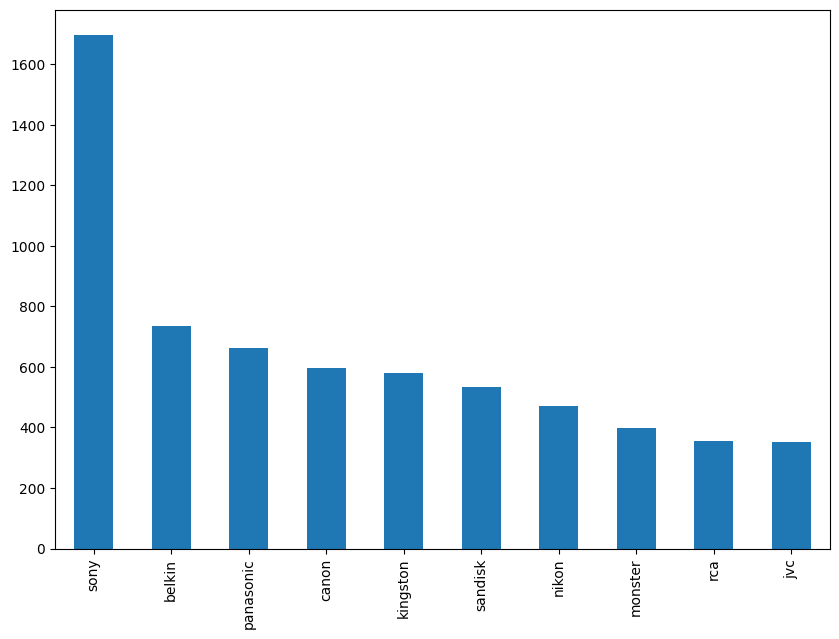

In [25]:
# Top most frequent brands
plt.subplots(figsize=(10,7))
products.brand_or_author.value_counts()[:10].plot(kind="bar")
plt.show()

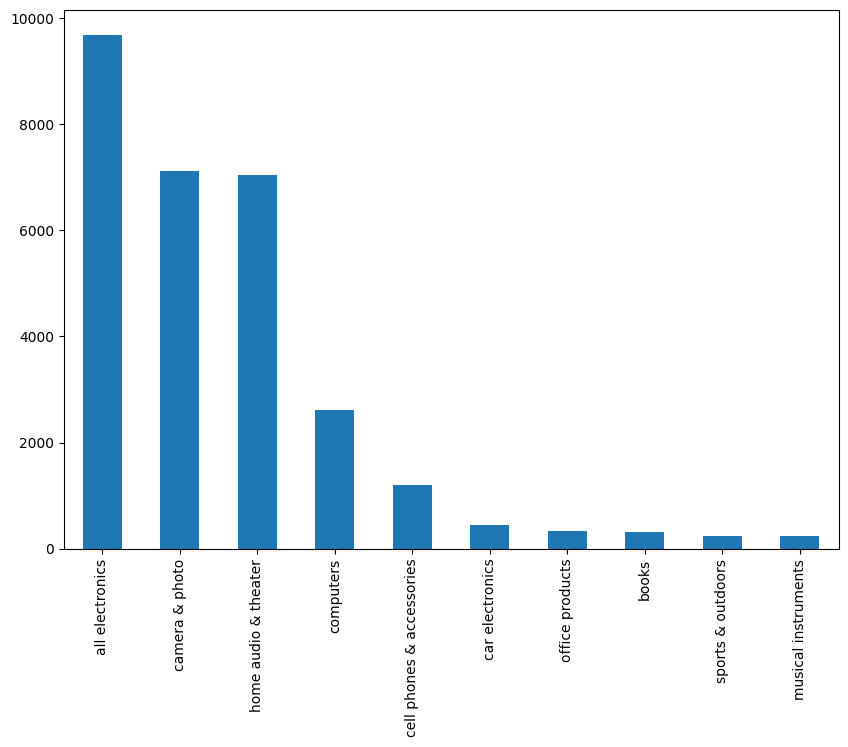

In [26]:
# Top 10 most frequent main categories
plt.subplots(figsize=(10,7))
products.main_category.value_counts()[:10].plot(kind="bar")
plt.show()
# print(products.main_cat.value_counts()[:10])

### 3.2 Using TfidfVectorizer

#### 3.2.1 Reusable Function Definitions

In [27]:
# Function that compute the cosine similarity matrix for an attribute
def compute_cosine_sim(attribute):
    # Remove stop words
    tf = TfidfVectorizer(analyzer='word', stop_words='english')
    # Construct the required TF-IDF matrix by fitting and transforming the data
    tfidf_matrix = tf.fit_transform(products[attribute])
    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    return cosine_sim

# Function that get product recommendations based on the 
# cosine similarity score of a certain attribute passed in
def get_recommendations(product_name, n, cosine_sim):
    # Build 1-dimensional array with product names
    indices = pd.Series(products.index, index=products['product_name'])
    
    # Get the index of the product that matches the names
    idx = indices[product_name]
    
    # Use the first product if there're multiple products with same name
    if (not isinstance(idx, (int, np.int64))):
        idx = indices[product_name].iloc[0]
        
    # Get the pairwise similarity scores of all products with that product
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the products based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Exclude the entered product
    sim_scores = [tup for tup in sim_scores if tup[0] != idx]
    # Get the scores of the N most similar products
    sim_scores = sim_scores[0:n]
    # Get the product indices
    product_indices = [i[0] for i in sim_scores]
    # Return the top N most similar products
    return products.iloc[product_indices]

# Function that get product name input from user
def getProductNameInput():
    name_input = input('Enter product name: ').lower()
    
    all_names = [products['product_name'][i] for i in range(len(products['product_name']))]
    
    if name_input not in all_names:
        print("Product not found, please enter again!")
    
    return name_input

#### 3.2.2 Recommending products based on "product_name"

In [28]:
# Get the cosine similarity matrix for product_name attribute
cosine_sim_product_name = compute_cosine_sim('product_name')

In [28]:
# Getting the product name input from user
name_input = getProductNameInput()

Enter product name:  Sony CFD-C1000 Compact Stereo System


In [30]:
# Top 20 most similar products
get_recommendations(name_input, 20, cosine_sim_product_name)

,product_id,product_name,brand_or_author,main_category,category_tags,ensemble
10580,B000066IUL,sony cfd-s500 portable am/fm/cd/cassette boombox,sony,home audio & theater,electronics portable audio & video boomboxes,sony cfd-s500 portable am/fm/cd/cassette boomb...
25730,B0001LXQIG,"sony cfd-f10 cd / radio / cassette recorder, s...",sony,home audio & theater,electronics portable audio & video boomboxes,"sony cfd-f10 cd / radio / cassette recorder, s..."
10594,B000066JQP,sony cfd-s200 cd radio cassette recorder boombox,sony,home audio & theater,electronics portable audio & video boomboxes,sony cfd-s200 cd radio cassette recorder boom...
11204,B000068EAO,sony cfd-g55 cd/cassette boombox (black),sony,home audio & theater,electronics portable audio & video boomboxes,sony cfd-g55 cd/cassette boombox (black) sony ...
21736,B0000BZL05,avenger c1000 drop-ceiling scissor clamp,avenger,camera & photo,electronics camera & photo lighting & studio l...,avenger c1000 drop-ceiling scissor clamp aveng...
25731,B0001LXQIQ,sony cfd-g500 cd radio cassette recorder boomb...,sony,home audio & theater,electronics portable audio & video boomboxes,sony cfd-g500 cd radio cassette recorder boomb...
16896,B00008WTBV,sony cfd-s250 cd/radio/cassette boombox (silver),sony,home audio & theater,electronics portable audio & video boomboxes,sony cfd-s250 cd/radio/cassette boombox (silve...
17170,B0000918VW,sony cfd-s550 cd/radio/cassette boombox (silver),sony,home audio & theater,electronics portable audio & video boomboxes,sony cfd-s550 cd/radio/cassette boombox (silve...
25729,B0001LXQJ0,sony cfd-s300 cd radio cassette recorder boomb...,sony,home audio & theater,electronics portable audio & video boomboxes,sony cfd-s300 cd radio cassette recorder boomb...
7850,B00005I9S1,sony mhcrg20 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,sony mhcrg20 compact stereo system (discontinu...


#### 3.2.3 Recommending products based on "brand_or_author"

In [46]:
# Get the cosine similarity matrix for brand_or_author attribute
cosine_sim_brand_or_author = compute_cosine_sim('brand_or_author')

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [53]:
# Top 20 most similar products
get_recommendations(name_input, 20, cosine_sim_brand_or_author)

,product_id,product_name,brand_or_author,main_category,category_tags,ensemble
863,7505405403,sony vgp-ac19v27 / vgp-ac19v19 19.5v 3.9a ac a...,sony,computers,electronics computers & accessories laptop acc...,sony vgp-ac19v27 / vgp-ac19v19 19.5v 3.9a ac a...
923,846130053X,audio component equalizers,sony,home audio & theater,electronics home audio home theater equalizers,audio component equalizers sony home audio & t...
2345,B00000DMA3,sony mdr-nc20 noise canceling headphones with ...,sony,home audio & theater,electronics headphones over-ear headphones,sony mdr-nc20 noise canceling headphones with ...
2347,B00000DMA4,sony des51 sport discman portable cd player (y...,sony,home audio & theater,electronics portable audio & video portable cd...,sony des51 sport discman portable cd player (y...
2348,B00000DM9W,sony icf-s79v weather band shower radio (disco...,sony,home audio & theater,electronics portable audio & video radios weat...,sony icf-s79v weather band shower radio (disco...
2596,B00000J48J,sony bcv615 camcorder/mavica battery charger f...,sony,camera & photo,electronics camera & photo accessories batteri...,sony bcv615 camcorder/mavica battery charger f...
2664,B00000J4J8,sony 10c90hfr 90 min hifi 10 pack (discontinue...,sony,home audio & theater,electronics accessories & supplies blank media,sony 10c90hfr 90 min hifi 10 pack (discontinue...
2668,B00000J4JL,sony 60 minute dvc premium chipless (single),sony,camera & photo,electronics camera & photo accessories blank v...,sony 60 minute dvc premium chipless (single) s...
2705,B00000J4VS,sony t-160 vhs video cassette (single),sony,home audio & theater,electronics camera & photo accessories blank v...,sony t-160 vhs video cassette (single) sony ho...
2710,B00000J4JI,sony high grade 120 min video cassette,sony,home audio & theater,electronics camera & photo accessories blank v...,sony high grade 120 min video cassette sony ho...


#### 3.2.4 Recommending products based on "main_category"

In [51]:
# Get the cosine similarity matrix for main_category attribute
cosine_sim_main_category = compute_cosine_sim('main_category')

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [55]:
# Top 20 most similar products
get_recommendations(name_input, 20, cosine_sim_main_category)

,product_id,product_name,brand_or_author,main_category,category_tags,ensemble
8,0132492776,wireless bluetooth headphones earbuds with mic...,enter the arena,home audio & theater,electronics headphones earbud headphones,wireless bluetooth headphones earbuds with mic...
15,0303532572,tdk hi8 mp120 premium performance camcorder vi...,tdk electronics corp,home audio & theater,electronics camera & photo accessories blank v...,tdk hi8 mp120 premium performance camcorder vi...
16,0302643370,the lord of the rings: return of the king - ex...,wb,home audio & theater,electronics accessories & supplies,the lord of the rings: return of the king - ex...
43,0545811295,i survived 10 book library,,home audio & theater,electronics accessories & supplies,i survived 10 book library home audio & theat...
70,0594478162,official nook audio ie250 earphones,nook,home audio & theater,electronics headphones earbud headphones,official nook audio ie250 earphones nook home ...
84,0594451647,barnes & noble hdtv adapter kit for nook hd an...,barnes & noble,home audio & theater,electronics computers & accessories tablet acc...,barnes & noble hdtv adapter kit for nook hd an...
92,0594514851,"barnes & noble nook oliver cover, black",barnes and noble,home audio & theater,electronics ebook readers & accessories covers,"barnes & noble nook oliver cover, black barnes..."
100,0594514843,"barnes & noble fits 6"" tablet / e-reader nook ...",barnes & noble,home audio & theater,electronics ebook readers & accessories,"barnes & noble fits 6"" tablet / e-reader nook ..."
113,0594514886,nook simple touch industriell stripe stand cov...,barnes & noble,home audio & theater,electronics ebook readers & accessories covers,nook simple touch industriell stripe stand cov...
130,0684873176,"the mutineer: rants, ravings, and missives fro...",enter the arena,home audio & theater,electronics headphones earbud headphones,"the mutineer: rants, ravings, and missives fro..."


#### 3.2.5 Recommending products based on "category_tags"

In [63]:
# Get the cosine similarity matrix for category_tags attribute
cosine_sim_category_tags = compute_cosine_sim('category_tags')

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [64]:
# Top 20 most similar products
get_recommendations(name_input, 20, cosine_sim_category_tags)

,product_id,product_name,brand_or_author,main_category,category_tags
2378,B00000J06D,rca rs1249 compact stereo system (discontinued...,rca,home audio & theater,electronics home audio compact radios & stereo...
2537,B00000J3NC,sharp mdm3 mini-disc/cd compact stereo system,sharp,home audio & theater,electronics home audio compact radios & stereo...
2548,B00000J3VK,panasonic sc-ak27 compact stereo system (disco...,panasonic,home audio & theater,electronics home audio compact radios & stereo...
2555,B00000J3TX,sharp cd-c3900 compact stereo system,sharp,home audio & theater,electronics home audio compact radios & stereo...
2564,B00000J3P0,fisher dcs-da300 executive microsystem,sanyo,home audio & theater,electronics home audio compact radios & stereo...
2662,B00000J4G0,fisher slim-1500 executive microsystem (discon...,sanyo,home audio & theater,electronics home audio compact radios & stereo...
2666,B00000J4GD,gpx s7799 3-cd compact stereo system (disconti...,gpx,home audio & theater,electronics home audio compact radios & stereo...
2766,B00000JBSN,jvc fs-7000 executive microsystem (discontinue...,jvc,home audio & theater,electronics home audio compact radios & stereo...
2898,B00000JFJR,jbl harmony cd personal music system,jbl,home audio & theater,electronics home audio compact radios & stereo...
2912,B00000JFEK,sony dhcmd-500 minidisc executive microsystem,sony,home audio & theater,electronics home audio compact radios & stereo...


#### 3.2.6 Recommending products based on a mixture of "product_name", "brand_or_author", "main_category" and "categories_tags"

In [29]:
# Get the cosine similarity matrix for ensemble attribute
cosine_sim_ensemble = compute_cosine_sim('ensemble')

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [30]:
# Top 20 most similar products
get_recommendations(name_input, 20, cosine_sim_ensemble)

,product_id,product_name,brand_or_author,main_category,category_tags
7850,B00005I9S1,sony mhcrg20 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...
9069,B00005T387,sony mhc-rg70av compact stereo system,sony,home audio & theater,electronics home audio compact radios & stereo...
3412,B00001XDXK,sony mhc-rxd10av home theater compact stereo s...,sony,home audio & theater,electronics home audio compact radios & stereo...
3504,B00001ZWT0,sony mhc-rxd5 compact stereo system (discontin...,sony,home audio & theater,electronics home audio compact radios & stereo...
5036,B00004VVUH,sony mhc-m300av compact stereo system (discont...,sony,home audio & theater,electronics home audio compact radios & stereo...
5040,B00004VVUF,sony mhc-bx5 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...
6561,B000050YFN,sony mhc-bx3 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...
7860,B00005I9RY,sony mhc-mg510av compact stereo system (discon...,sony,home audio & theater,electronics home audio compact radios & stereo...
3413,B00001XDXR,sony cmt-md1 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...
26984,B00022RV8A,sony cmt-cpx22 compact stereo micro audio syst...,sony,home audio & theater,electronics home audio compact radios & stereo...


### 3.3 Using CountVectorizer

#### 3.3.1 Reusable Function Definitions

In [31]:
# Function that compute the cosine similarity matrix for an attribute
def get_cosine_sim_and_matrix_cv(attribute):
    # Initialize vectorizer
    # min_df = rare words, max_df = most used words
    vect = CountVectorizer(analyzer = 'word', stop_words = 'english')
    # Fit into the attribute
    vect.fit(products[attribute])
    cv_matrix = vect.transform(products[attribute])
    
    cosine_sim = cosine_similarity(cv_matrix, cv_matrix)
    
    return [cosine_sim, cv_matrix]
    
def get_recommendations_cv(product_name, n, cosine_sim, matrix):
    # Build 1-dimensional array with product names
    indices = pd.Series(products.index, index=products['product_name'])
    
    # Get the index of the product that matches the names
    name_idx = indices[product_name]
    
    # Use the first product if there're multiple products with same name
    if (not isinstance(name_idx, (int, np.int64))):
        name_idx = indices[product_name].iloc[0]
        
    # Find out what features have been considered by the vectorizer for a given name 
    feature_array = np.squeeze(matrix[name_idx].toarray()) # squeeze activity matrix into array
    idx = np.where(feature_array > 0)
        
    # Cosine similarity with other similar attributes
    top_n_idx = np.flip(np.argsort(cosine_sim[name_idx,]), axis = 0)[0:n+1]
    top_n_sim_values = cosine_sim[name_idx, top_n_idx]
    
    # Find top n with values > 0
    top_n_idx = top_n_idx[top_n_sim_values > 0]
    scores = top_n_sim_values[top_n_sim_values > 0]
    
    # Exclude entered product
    for idx, i in enumerate(top_n_idx):
        if i == name_idx:
            top_n_idx = np.delete(top_n_idx, idx)
            scores = np.delete(scores, idx)
    
    return pd.DataFrame(
        {
            "product_name": products['product_name'].iloc[top_n_idx].values,
            "brand_or_author": products['brand_or_author'].iloc[top_n_idx].values,
            "main_category": products['main_category'].iloc[top_n_idx].values,
            "category_tags": products['category_tags'].iloc[top_n_idx].values,
            "score": scores
        },
        columns = ["product_name", "brand_or_author", "main_category", "category_tags", "score"]
    )

# Function that get product name input from user
def getProductNameInput():
    name_input = input('Enter product name: ').lower()
    
    all_names = [products['product_name'][i] for i in range(len(products['product_name']))]
    
    if name_input not in all_names:
        print("Product not found, please enter again!")
        
    return name_input

#### 3.3.2 Recommending products based on "product_name"

In [44]:
# Get the cosine similarity matrix for product_name attribute
result = get_cosine_sim_and_matrix_cv('product_name')
cosine_sim_product_name_cv = result[0]
matrix_product_name_cv = result[1]

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [45]:
# Top 20 most similar products
get_recommendations_cv(name_input, 20, cosine_sim_product_name_cv, matrix_product_name_cv)

,product_name,brand_or_author,main_category,category_tags,score
0,sony mhc-rg70av compact stereo system,sony,home audio & theater,electronics home audio compact radios & stereo...,0.600000
1,sony mhcrg20 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.547723
2,sony mhc-mg510av compact stereo system (discon...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.507093
3,sony cmt-md1 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.507093
4,sony mhc-bx5 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.507093
5,sony mhc-m300av compact stereo system (discont...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.507093
6,sony mhc-bx3 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.507093
7,sony mhc-rxd5 compact stereo system (discontin...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.507093
8,jvc mxj300 compact stereo system,jvc,home audio & theater,electronics home audio compact radios & stereo...,0.447214
9,aiwa nsxds11 compact stereo system,aiwa,home audio & theater,electronics home audio compact radios & stereo...,0.447214


#### 3.3.3 Recommending products based on "brand_or_author"

In [59]:
# Get the cosine similarity matrix for brand_or_author attribute
result = get_cosine_sim_and_matrix_cv('brand_or_author')
cosine_sim_brand_or_author_cv = result[0]
matrix_brand_or_author_cv = result[1]

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [60]:
# Top 20 most similar products
get_recommendations_cv(name_input, 20, cosine_sim_brand_or_author_cv, matrix_brand_or_author_cv)

,product_name,brand_or_author,main_category,category_tags,score
0,"sony dsr-pdx10 professional 1/4.7"" 16:9 3ccd d...",sony,camera & photo,electronics camera & photo video camcorders,1.0
1,"sony cdp-e210 17"" crt monitor",sony,computers,electronics computers & accessories monitors,1.0
2,"sony sdm-n50 15"" lcd monitor",sony,computers,electronics computers & accessories monitors,1.0
3,sony vmc20fr av cable,sony,camera & photo,electronics camera & photo accessories cables ...,1.0
4,sony lcsva1 soft carrying case,sony,camera & photo,electronics camera & photo bags & cases camcor...,1.0
5,"sony sdm-m51 15"" lcd monitor",sony,computers,electronics computers & accessories monitors,1.0
6,sony vclhg2030 telephoto conversion lens for d...,sony,camera & photo,electronics camera & photo accessories camcord...,1.0
7,"sony cdp-e500 21"" crt monitor",sony,computers,electronics computers & accessories monitors,1.0
8,sony hvlfdh4 video flash light for the dcrhc40...,sony,camera & photo,electronics camera & photo accessories,1.0
9,sony lcmtrvy semi soft camcorder carrying case,sony,camera & photo,electronics camera & photo bags & cases camcor...,1.0


#### 3.3.4 Recommending products based on "main_category"

In [61]:
# Get the cosine similarity matrix for main_category attribute
result = get_cosine_sim_and_matrix_cv('main_category')
cosine_sim_main_category_cv = result[0]
matrix_main_category_cv = result[1]

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [62]:
# Top 20 most similar products
get_recommendations_cv(name_input, 10, cosine_sim_main_category_cv, matrix_main_category_cv)

,product_name,brand_or_author,main_category,category_tags,score
0,tdk systems cdrw 80min 700mb 12x hi-speed spin...,tdk systems,home audio & theater,electronics accessories & supplies blank media...,1.0
1,panasonic rphc100 noise cancelling monitor hea...,panasonic,home audio & theater,electronics headphones,1.0
2,juke jam 40gb mp3 player,digital networks,home audio & theater,electronics portable audio & video mp3 & mp4 p...,1.0
3,philips cdr765 audio compact disc recorder,philips,home audio & theater,electronics home audio stereo system component...,1.0
4,audiosource psw100 100 watt 10-inch powered su...,audiosource,home audio & theater,electronics home audio speakers subwoofers,1.0
5,sony 8cm double-sided dvd-r with hangtab - sin...,sony,home audio & theater,electronics accessories & supplies blank media...,1.0
6,atlantic cd storage rack (elf464c47),atlantic,home audio & theater,electronics accessories & supplies audio & vid...,1.0
7,verbatim digitalmovie dvd-r recordable media 4...,verbatim,home audio & theater,electronics accessories & supplies blank media...,1.0
8,memorex mks2451 karaoke system with echo (disc...,memorex,home audio & theater,electronics portable audio & video cassette pl...,1.0
9,koss ur29 stereo headphone,koss,home audio & theater,electronics headphones,1.0


#### 3.3.5 Recommending products based on "category_tags"

In [65]:
# Get the cosine similarity matrix for category_tags attribute
result = get_cosine_sim_and_matrix_cv('category_tags')
cosine_sim_category_tags_cv = result[0]
matrix_category_tags_cv = result[1]

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [66]:
# Top 20 most similar products
get_recommendations_cv(name_input, 20, cosine_sim_category_tags_cv, matrix_category_tags_cv)

,product_name,brand_or_author,main_category,category_tags,score
0,panasonic sc-ak320s 300-watt 5-cd shelf system...,panasonic,home audio & theater,electronics home audio compact radios & stereo...,1.0
1,panasonic sc-dk2 5-dvd home theater compact st...,panasonic,home audio & theater,electronics home audio compact radios & stereo...,1.0
2,bose lifestyle 50 home theater system (black) ...,bose,home audio & theater,electronics home audio compact radios & stereo...,1.0
3,philips fw-r8 cd recorder executive microsystem,philips,home audio & theater,electronics home audio compact radios & stereo...,1.0
4,philips fwr7 compact stereo system with integr...,philips,home audio & theater,electronics home audio compact radios & stereo...,1.0
5,sony cmt-ep707 3-disc cd desktop microsystem (...,sony,home audio & theater,electronics home audio compact radios & stereo...,1.0
6,philips fw-d5 dvd home theater compact stereo ...,philips,home audio & theater,electronics home audio compact radios & stereo...,1.0
7,philips mz3 executive microsystem (discontinue...,philips,home audio & theater,electronics home audio compact radios & stereo...,1.0
8,panasonic sc-pm22 executive microsystem (disco...,panasonic,home audio & theater,electronics home audio compact radios & stereo...,1.0
9,jvc fs-h100 micro audio system,jvc,home audio & theater,electronics home audio compact radios & stereo...,1.0


#### 3.3.6 Recommending products based on a mixture of "product_name", "brand_or_author", "main_category" and "categories_tags"

In [32]:
# Get the cosine similarity matrix for ensemble attribute
result = get_cosine_sim_and_matrix_cv('ensemble')
cosine_sim_ensemble_cv = result[0]
matrix_ensemble_cv = result[1]

In [ ]:
# Getting the product name input from user
name_input = getProductNameInput()

In [33]:
# Top 20 most similar products
get_recommendations_cv(name_input, 10, cosine_sim_ensemble_cv, matrix_ensemble_cv)

,product_name,brand_or_author,main_category,category_tags,score
0,sony mhc-rg70av compact stereo system,sony,home audio & theater,electronics home audio compact radios & stereo...,0.928571
1,sony mhcrg20 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.912421
2,sony mhc-m300av compact stereo system (discont...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.897085
3,sony mhc-mg510av compact stereo system (discon...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.897085
4,sony cmt-md1 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.897085
5,sony mhc-bx5 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.897085
6,sony mhc-bx3 compact stereo system (discontinu...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.897085
7,sony mhc-rxd5 compact stereo system (discontin...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.897085
8,sony mhc-rxd10av home theater compact stereo s...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.889052
9,sony cmt-cpx22 compact stereo micro audio syst...,sony,home audio & theater,electronics home audio compact radios & stereo...,0.881917
